# Energy Label Transition Model - Base model

**This notebook provides a working skeleton to start your modelling project from**


## 0. About the Model

### Model Narrative
This agent-based model simulates the adoption of energy efficiency improvements among homeowners in a city. **Owners** are autonomous agents who evaluate whether to upgrade their house's energy label based on their financial capacity. **Houses** are passive agents that maintain their energy efficiency rating (ranging from G, the worst, to A+, the best). This base model explores how financial constraints influence the rate and pattern of energy efficiency transitions over time, providing insights into policy interventions that could accelerate sustainable housing improvements.


### How to use this Model
This base model provides a minimal working skeleton. The choices made in this model are primitive. You should replace them with logic that better fits your research question and ideas. For example, the use of grid space is provided as a simplified example; you might want to consider a more realistic network structure instead. 

## 1. Import Libraries

Import the necessary libraries for the agent-based model.

In [44]:
# Core Mesa library for agent-based modeling
import mesa

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Random
import random
import gc

# Type hints for better code documentation
from typing import Dict, List, Tuple

# Print Mesa version to confirm correct installation
print(f"Mesa version: {mesa.__version__}")
print("Required: Mesa 3.0.3 or higher")   


Mesa version: 3.3.1
Required: Mesa 3.0.3 or higher


## 2. Functions

These functions provide basic model mechanics using simple linear relationships as examples. You can also decide to remove them from the model and replace them with different functions that better suit your ideas.

In [2]:
def label_to_numeric(label: str) -> int:
    """Convert energy label to numeric value (G=0 to A+=7)."""
    # Dictionary mapping letter labels to numbers for calculations
    mapping = {"G": 0, "F": 1, "E": 2, "D": 3, "C": 4, "B": 5, "A": 6, "A+": 7}
    return mapping.get(label, 0)  # Return 0 if label not found


def numeric_to_label(value: float) -> str:
    """Convert numeric value back to energy label string."""
    # Dictionary mapping numbers back to letter labels
    mapping = {0: "G", 1: "F", 2: "E", 3: "D", 4: "C", 5: "B", 6: "A", 7: "A+"}
    rounded = int(round(value))  # Round to nearest integer
    rounded = max(0, min(7, rounded))  # Clamp to valid range [0, 7]
    return mapping[rounded] # This returns the corresponding label


def calculate_transition_cost(current_label: str, target_label: str) -> float:
    """Calculate cost to transition from current to target label.
    
    Simple linear cost model: 10,000€ per label step improvement.
    Example: D→B costs 20,000€ (2 steps × 10,000€)
    """
    # Calculate how many label steps need to be improved
    gap = label_to_numeric(target_label) - label_to_numeric(current_label)
    
    # If already at or above target, no cost needed
    if gap <= 0:
        return 0.0
    
    # Linear cost: €10,000 per label step
    return gap * 10000

def calculate_house_satisfaction(current_label: str, market_value: str, energy_label_pref: float, market_value_pref: float):
    """Calculate the house satisfaction based on the current_label and the market_value."""

    house_satisfaction = label_to_numeric(current_label) * energy_label_pref + market_value * market_value_pref
    
    return house_satisfaction

def calculate_max_label_upgrade(financial_status: int, current_label: str):
    """Calculate the maximum label upgrade possible with the financial status."""

    label_steps = max(financial_status, 0) // 10000 # check the number of label_steps possible with the financial status

    max_label = label_to_numeric(current_label) + label_steps

    if max_label > 7:
        max_label = 7
    
    return numeric_to_label(max_label)

def normal_between_0_and_1(mu=0.5, sigma=0.15):
    x = random.gauss(mu, sigma)
    return min(max(x, 0.0), 1.0)

def calculate_max_value_upgrade(financial_status: int, market_value_current: float):
    value_steps = max(financial_status, 0) // 10000

    max_value = market_value_current + value_steps

    return max_value

def calculate_neighbour_chillness(self):
            x, y = self.house.pos
            neighbours = self.model.grid.get_neighbors((x, y), moore=True, include_center=False)
            neighbours_chillness = [
                agent.chillness for agent in neighbours
                if isinstance(agent, Owner)]

            if not neighbours_chillness:
                return 0.5 #0.5 is considered neutral
            
            return sum(neighbours_chillness) / len(neighbours_chillness)

## 3. House Class

Houses are Mesa agents fixed at grid positions with energy efficiency labels.

**Key Points:**
- Houses inherit from `mesa.Agent` to enable grid placement and data collection
- Houses are **passive** - they don't make decisions
- Each grid cell can have at most one house
- Houses can be vacant (no owner) or occupied

In [3]:
class House(mesa.Agent):
    """House agent - passive container for energy efficiency information."""

    def __init__(self, model, current_label: str):
        super().__init__(model)  # Initialize Mesa Agent. Note that mesa will assign a unique ID to each agent instance
        self.current_label = current_label  # Energy label (A+ to G)
        self.owner_id = None  # ID of owner living here (None if vacant)
    
    def step(self):
        """Houses are passive - no actions needed each time step."""
        pass

## 4. Owner Class

Owners make simple decisions about transitioning.

**Key Points:**
- They can transition house label **ONCE**
- They use simple affordability-based decision

In [4]:
class Owner(mesa.Agent):
    """Homeowner who makes transition decisions."""
    
    def __init__(self, model, financial_status: float, energy_label_pref: float, market_value_pref: float, chillness: float):
        super().__init__(model)  # Initialize Mesa Agent
        self.financial_status = financial_status  # Available budget (€)
        self.energy_label_pref = energy_label_pref
        self.market_value_pref = market_value_pref
        self.chillness = chillness
        self.house = None  # Reference to House object (assigned later)
        self.has_transitioned = 0  # Track if already upgraded
        self.has_moved = 0
        self.has_moved_and_transitioned = 0
    
    def step(self):
        """Called each year - owner decides whether to transition."""

        self.neighbour_chillness = calculate_neighbour_chillness(self) - 0.5

        self.curr_house_sat = calculate_house_satisfaction(
            self.house.current_label, self.house.market_value, self.energy_label_pref, self.market_value_pref) + self.model.importance_of_neighbours * self.neighbour_chillness
        
        max_label_upgrade = calculate_max_label_upgrade(self.financial_status, self.house.current_label)

        cost = calculate_transition_cost(self.house.current_label, max_label_upgrade)

        # Investigate potential benefits of upgrading the label
        pot_house_sat_upg = calculate_house_satisfaction(
            max_label_upgrade, self.house.market_value, self.energy_label_pref, self.market_value_pref) + self.model.importance_of_neighbours * self.neighbour_chillness

        # Investigate potential benefits of moving
        max_value = calculate_max_value_upgrade(self.financial_status, self.house.market_value)
        empty_houses_in_budget = [h for h in self.model.agents_by_type[House].select(lambda h: h.owner_id is None and h.market_value <= max_value)]

        pot_house_sat_move = float("-inf")
        self.best_house_move = None

        for house in empty_houses_in_budget:
            moving_satisfaction = calculate_house_satisfaction(
                house.current_label, house.market_value, self.energy_label_pref, self.market_value_pref)
            if moving_satisfaction > pot_house_sat_move:
                pot_house_sat_move = moving_satisfaction
                self.best_house_move = house

        pot_house_sat_move_and_upg = float("-inf")
        self.best_house_move_and_upg = None
        
        for house in empty_houses_in_budget:
            rest_income = self.financial_status + self.house.market_value * 10000 - house.market_value * 10000
            pot_label_upgrade = calculate_max_label_upgrade(rest_income, house.current_label)
            move_and_upgrade_satisfaction = calculate_house_satisfaction(
                pot_label_upgrade, house.market_value, self.energy_label_pref, self.market_value_pref)
            if move_and_upgrade_satisfaction > pot_house_sat_move_and_upg:
                pot_house_sat_move_and_upg = move_and_upgrade_satisfaction
                self.best_house_move_and_upg = house

        max_sat = max(self.curr_house_sat, pot_house_sat_upg, pot_house_sat_move, pot_house_sat_move_and_upg)
        self.wants_to_move = False
        self.wants_to_move_and_upgrade = False

        if self.house is not None and max_sat != self.curr_house_sat:
            if max_sat == pot_house_sat_upg:
                self.financial_status = self.financial_status - cost
                self.curr_house_sat = pot_house_sat_upg
                self.house.current_label = max_label_upgrade
                self.has_transitioned += 1

            elif max_sat == pot_house_sat_move:
                self.wants_to_move = True
            
            elif max_sat == pot_house_sat_move_and_upg:
                self.wants_to_move_and_upgrade = True


## 5. City Model Class

The City model manages the simulation.

**Key Components:**
- Simple grid (10×10) (feel free to change the grid structure or size)
- Includes agents
- Manages the data collection
- Runs the simulation and triggers agent steps

In [5]:
class City(mesa.Model):
    """City model with houses and owners on a grid."""
    
    def __init__(
        self,
        num_houses: int = 50, # Total number of houses in the model
        num_owners: int = 40, # Total number of owners in the model
        grid_size: int = 10, # Size of the grid (grid_size x grid_size). Note that you can define the width and height separately with different dimensions if desired
        financial_status_mean: float = 30000, # Average financial status of owners (€). This helps controlling the affordability of transitions in the base model
        financial_status_std: float = 5000, # Standard deviation of financial status (€). This helps controlling the affordability of transitions in the base model
        label_distribution: Dict[str, float] = None, # Distribution of energy labels among houses. This allows customizing the initial state of the housing stock
        market_value_distribution: tuple = (0.5, 0.5),
        average_energy_label_preference: float = 0.5,
        variance_energy_label_preference: float = 0.2,
        importance_of_neighbours: float = 1.0,
        seed: int = None
    ):
        # Initialize Mesa Model with seed (Mesa 3.0 handles random number generation)
        super().__init__(seed=seed)
        
        # Validate inputs. Return an error if the number of owners is greater than the number of houses
        if num_owners > num_houses:
            raise ValueError(f"Cannot have more owners ({num_owners}) than houses ({num_houses})!")
        
        # Assign parameters to model attributes
        self.num_houses = num_houses
        self.num_owners = num_owners
        self.grid_size = grid_size
        self.financial_status_mean = financial_status_mean
        self.financial_status_std = financial_status_std
        self.market_value_distribution = market_value_distribution
        self.average_energy_label_preference = average_energy_label_preference
        self.variance_energy_label_preference = variance_energy_label_preference
        self.importance_of_neighbours = importance_of_neighbours
        
        # Default label distribution (more poor labels, fewer good ones). If this line is confusing, please ask teh instructor.
        if label_distribution is None:
            self.label_distribution = {
                "G": 0.05, "F": 0.10, "E": 0.20, "D": 0.30,
                "C": 0.20, "B": 0.10, "A": 0.04, "A+": 0.01
            }
        else:
            self.label_distribution = label_distribution

        # Initialize grid using Mesa's MultiGrid object (please read the documentation for more details)
        self.grid = mesa.space.MultiGrid(grid_size, grid_size, torus=False)
        
        # Create agents
        self.create_houses()
        self.create_owners()

        # Assign houses to owners based on their grid positions
        self.assign_houses_to_owners()
        
        # Set up data collection
        self.setup_data_collection()
        self.datacollector.collect(self)
    
    def compute_location_value(self, pos):
        """Returns a location value between 0 and 1 based on distance to center."""

        x, y = pos

        # geometric center (works for both even and odd grid sizes)
        cx = (self.grid_size - 1) / 2
        cy = (self.grid_size - 1) / 2

        # Euclidean distance to center
        dist = ((x - cx)**2 + (y - cy)**2)**0.5

        # maximum possible distance on the grid (corner to center)
        max_dist = ((cx)**2 + (cy)**2)**0.5

        # normalize: center → 1.0, farthest corner → 0.0
        location_value = 1 - (dist / max_dist)

        return location_value

    def create_houses(self):
        """Create and place houses on grid."""
        # Extract label names and probabilities from distribution
        labels = list(self.label_distribution.keys())
        probs = list(self.label_distribution.values())
        
        # Check if we have enough grid cells for all houses
        total_cells = self.grid_size * self.grid_size
        if self.num_houses > total_cells: #raise error if not enough space
            raise ValueError(f"Cannot place {self.num_houses} houses on a {self.grid_size}×{self.grid_size} grid (only {total_cells} cells available)!")
        
        # Generate all possible grid positions
        all_positions = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]
        
        # Sample unique positions without replacement (much more efficient than while loop)
        selected_positions = self.random.sample(all_positions, self.num_houses)
        
        # Create houses and place them at the selected positions
        for pos in selected_positions:
            # Randomly select initial label based on distribution
            label = self.random.choices(labels, weights=probs, k=1)[0] # this line means that we are selecting one label based on the weights provided in probs
            house = House(self, label)
            house.location_value = self.compute_location_value(pos)
            house.market_value = (house.location_value * self.market_value_distribution[0] + label_to_numeric(house.current_label) / 7 * self.market_value_distribution[1]) * 7
            self.grid.place_agent(house, pos) # Mesa's method for placing agents on a grid
    
    def create_owners(self):
        """Create and place owners at house positions."""
        # Use Mesa's AgentSet.get() to extract positions. Refer to Mesa 3.0.3 documentation to learn more about AgentSet and filtering
        house_positions = self.agents_by_type[House].get("pos") # Note that agents_by_type returns a list
        
        # Ensure we don't try to place more owners than available houses. Note that this is redundant given the earlier check of num_owners being less or equal to num_houses, but added here for safety
        if self.num_owners > len(house_positions):
            raise ValueError(f"Cannot place {self.num_owners} owners in {len(house_positions)} houses!")
        
        # Sample unique positions without replacement to ensure each owner gets a different house
        selected_positions = self.random.sample(house_positions, self.num_owners)
        
        # Create owners agents and assign each to a unique house position
        for pos in selected_positions:
            # Draw financial status from normal distribution. This help us ensure that the mean that we define is respected while allowing for variability
            financial_status = max(0, self.random.gauss(
                self.financial_status_mean,
                self.financial_status_std
            ))  # Ensure non-negative

            energy_label_pref = min(max(self.random.gauss(self.average_energy_label_preference, self.variance_energy_label_preference), 0.0), 1.0)
            market_value_pref = 1 - energy_label_pref
            chillness = self.random.random()
            
            # create owner agent instance using the drawn financial status
            owner = Owner(self, financial_status, energy_label_pref, market_value_pref, chillness)
            
            # Place owner at the selected house position
            self.grid.place_agent(owner, pos)
    
    def assign_houses_to_owners(self):
        """Assign houses to owners based on their grid positions.
        
        Since owners are placed at house positions, we just find the house at the same cell.
        """
        owners = self.agents_by_type[Owner]
        
        for owner in owners:
            # Get all agents at this cell - should be exactly one house and one owner
            cellmates = self.grid.get_cell_list_contents([owner.pos])
            
            # Safety check: ensure exactly 2 agents (house + owner) at this position
            if len(cellmates) != 2:
                raise ValueError(f"Expected 2 agents at position {owner.pos}, found {len(cellmates)}")
            
            # Find the house (the agent that is not the owner)
            # cellmates[0] and cellmates[1] are the two agents - one is owner, other is house
            house = cellmates[0] if cellmates[0] is not owner else cellmates[1]

            # Link them together
            owner.house = house
            house.owner_id = owner.unique_id
    
    def setup_data_collection(self):
        """Configure data collection using Mesa's DataCollector."""
        self.datacollector = mesa.DataCollector(
            # Model-level metrics
            model_reporters={
                "Num_Transitioned": self.count_transitions,
                "Num_Movings": self.count_moves,
                "Num_Moving_and_Transitioned": self.count_moves_and_transitions,
                "Avg_Label_Numeric": lambda m: label_to_numeric(m.get_current_avg_label()),
                "Avg_Label": self.get_current_avg_label
            },

            # Agent-level metrics
            agent_reporters={

                # Generic info
                "Agent_Type": lambda a: type(a).__name__,

                # --- Owner attributes ---
                "Financial_Status": lambda a: getattr(a, 'financial_status', None),
                "Has_Transitioned": lambda a: getattr(a, 'has_transitioned', None),
                "Has_Moved": lambda a: getattr(a, 'has_moved', None),
                "Has_Moved_and_Transitioned": lambda a: getattr(a, 'has_moved_and_transitioned', None),

                # --- House attributes (directly from House agents) ---
                "House_Label": lambda a: a.current_label if isinstance(a, House) else None
            }
        )
  
    def get_current_avg_label(self) -> str:
        """Calculate average energy label across occupied houses."""
        # Use Mesa's agents_by_type and AgentSet.select(). Please check Mesa 3.0.3 documentation to learn more about AgentSet and filtering
        occupied = self.agents_by_type[House].select(lambda h: h.owner_id is not None) # Stare a bit at this line to understand how it works! a lot is happening in this line
        
        # Return default if no occupied houses
        if len(occupied) == 0:
            return "D"
        
        # Convert labels to numbers, calculate average, convert back to label
        total = sum(label_to_numeric(h.current_label) for h in occupied)
        avg = total / len(occupied)
        return numeric_to_label(avg)
    
    def count_transitions(self) -> int:
        """Count owners who have transitioned."""
        # Use Mesa's agents_by_type to get all owners
        owners = self.agents_by_type[Owner] 
        return sum(o.has_transitioned for o in owners)
    
    def count_moves(self):
        owners = self.agents_by_type[Owner]
        return sum(o.has_moved for o in owners)
    
    def count_moves_and_transitions(self):
        owners = self.agents_by_type[Owner]
        return sum(o.has_moved_and_transitioned for o in owners)
    
    def relocation_step(self):
        # Build interest dict using house IDs
        interest = {house.unique_id: [] for house in self.agents_by_type[House].select(lambda h: h.owner_id is None)}
        # print("Empty houses in interest dict:", list(interest.keys()))
        for owner in self.agents_by_type[Owner]:
            if owner.wants_to_move and owner.best_house_move is not None:
                interest[owner.best_house_move.unique_id].append(owner)
            if owner.wants_to_move_and_upgrade and owner.best_house_move is not None:
                interest[owner.best_house_move_and_upg.unique_id].append(owner)

        for house_id, candidates in interest.items():
            if not candidates:
                continue

            # Pick winner by highest financial status
            winner = max(
                candidates, key=lambda o: o.financial_status + (o.house.market_value * 10000))

            # Get the house object
            house = next(h for h in self.agents_by_type[House] if h.unique_id == house_id)

            # Vacate old house
            if winner.house is not None:
                old_house = winner.house
                winner.house.owner_id = None

            # Assign new house
            house.owner_id = winner.unique_id
            winner.house = house

            value_diff = house.market_value - old_house.market_value
            cost_eur = value_diff * 10000
            winner.financial_status -= cost_eur

            if winner.wants_to_move_and_upgrade is True:
                label_upgrade = calculate_max_label_upgrade(winner.financial_status, winner.house.current_label)
                cost = calculate_transition_cost(winner.house.current_label, label_upgrade)
                new_house_sat = calculate_house_satisfaction(label_upgrade, winner.house.market_value, winner.energy_label_pref, winner.market_value_pref)
                
                winner.financial_status = winner.financial_status - cost
                winner.curr_house_sat = new_house_sat
                winner.house.current_label = label_upgrade
                winner.has_moved_and_transitioned += 1
            else:
                winner.has_moved += 1

            # Reset move flags
            winner.best_house_move = None
            winner.best_house_move_and_upg = None
 
    def step(self):
        """Execute one simulation step (one year)."""
        # Use Mesa's AgentSet.do() to call step() on only owners
        # More efficient than calling step on all agents since houses are passive. 
        self.agents_by_type[Owner].do("step") # If you want to step all the agents, you can use self.agents.do("step")
        self.relocation_step()
        # Collect data for this time step
        self.datacollector.collect(self)

## 6. Run Single Simulation

Create and run the model for 30 years with default parameters.

In [6]:
# Create and run model
print("Creating model...")
model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    seed=42
) # note that you can decide to not define the values for the parameters. In this case, default values defined in the model class will be used

# Store initial label counts for comparison later
initial_label_counts = {}
for house in model.agents_by_type[House]:
    label = house.current_label
    initial_label_counts[label] = initial_label_counts.get(label, 0) + 1

print("\n" + "="*60)
print("INITIAL STATE (Year 0)")
print("="*60)
print(f"Number of houses:       {model.num_houses}")
print(f"Number of owners:       {model.num_owners}")
print(f"Grid size:              {model.grid_size} × {model.grid_size}")
print(f"Initial avg label:      {model.get_current_avg_label()}")
print("="*60)

# Run simulation
print("\nRunning simulation for 30 years...")
num_years = 30

for year in range(num_years):
    model.step()
    if (year + 1) % 10 == 0:
        print(f"  Year {year + 1}: Avg label = {model.get_current_avg_label()}, "
              f"Transitions = {model.count_transitions()}")

print("\n" + "="*60)
print(f"FINAL STATE (Year {num_years})")
print("="*60)
print(f"Final avg label:        {model.get_current_avg_label()}")
print(f"Total transitions:      {model.count_transitions()} / {model.num_owners} "
      f"({model.count_transitions()/model.num_owners*100:.1f}%)")
print("="*60)

Creating model...

INITIAL STATE (Year 0)
Number of houses:       50
Number of owners:       40
Grid size:              10 × 10
Initial avg label:      D

Running simulation for 30 years...
  Year 10: Avg label = A, Transitions = 19
  Year 20: Avg label = A, Transitions = 19
  Year 30: Avg label = A, Transitions = 19

FINAL STATE (Year 30)
Final avg label:        A
Total transitions:      19 / 40 (47.5%)


## 7. Data Collection

Mesa's DataCollector makes it easy to access simulation data as Pandas DataFrames.

In [7]:
# Get model-level data (one row per year)
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,Num_Transitioned,Num_Movings,Num_Moving_and_Transitioned,Avg_Label_Numeric,Avg_Label
0,0,0,0,3,D
1,2,0,5,3,D
2,7,0,8,4,C
3,17,1,10,5,B
4,17,1,12,5,B
5,18,1,14,5,B
6,19,1,19,6,A
7,19,1,20,6,A
8,19,1,20,6,A
9,19,1,20,6,A


In [8]:
# Get agent-level data (one row per owner per year)
agent_data = model.datacollector.get_agent_vars_dataframe()
house_data = agent_data[agent_data['Agent_Type'] == 'House'].iloc[:, 12:]
house_data

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), ...]

[1550 rows x 0 columns]

In [9]:
# View just the owner data
owner_data = agent_data[agent_data['Agent_Type'] == 'Owner'].iloc[:, :12]
owner_data

Agent_Type  Financial_Status  Has_Transitioned  Has_Moved  \
Step AgentID                                                             
0    51           Owner      38339.690893               0.0        0.0   
     52           Owner      35497.403014               0.0        0.0   
     53           Owner      26673.818848               0.0        0.0   
     54           Owner      36534.693063               0.0        0.0   
     55           Owner      35891.786484               0.0        0.0   
...                 ...               ...               ...        ...   
30   86           Owner        758.319727               0.0        0.0   
     87           Owner        349.861513               1.0        0.0   
     88           Owner       1245.574083               0.0        0.0   
     89           Owner        964.259044               0.0        0.0   
     90           Owner        311.738531               0.0        0.0   

              Has_Moved_and_Transitioned House_Label  
Step AgentID                                          
0    51                              0.0        None  
     52                              0.0        None  
     53                              0.0        None  
     54                              0.0        None  
     55                              0.0        None  
...                                  ...         ...  
30   86                              1.0        None  
     87                              0.0        None  
     88                              1.0        None  
     89                              1.0        None  
     90                              1.0        None  

[1240 rows x 6 columns]

**Make sure you learn Pandas basics to manipulate and analyze Pandas DataFrame (i.e.,the collected data) effectively.**

## 8. Visualizations

### 8.1 Time Series: Model Dynamics

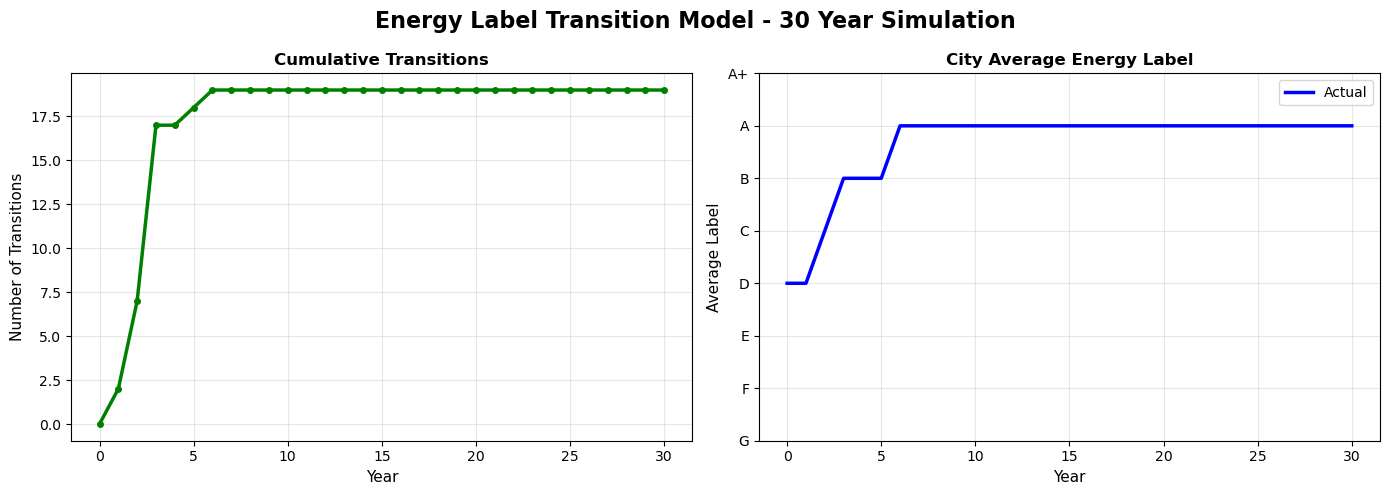

In [10]:
# Visualize time series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Energy Label Transition Model - 30 Year Simulation', 
             fontsize=16, fontweight='bold')

# Plot 1: Cumulative transitions
axes[0].plot(model_data.index, model_data['Num_Transitioned'], 
             linewidth=2.5, color='green', marker='o', markersize=4)
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Number of Transitions', fontsize=11)
axes[0].set_title('Cumulative Transitions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Average label
axes[1].plot(model_data.index, model_data['Avg_Label_Numeric'], 
             linewidth=2.5, color='blue', label='Actual')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Average Label', fontsize=11)
axes[1].set_title('City Average Energy Label', fontsize=12, fontweight='bold')
axes[1].set_yticks(range(8))
axes[1].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2 Label Distribution: Initial vs Final State

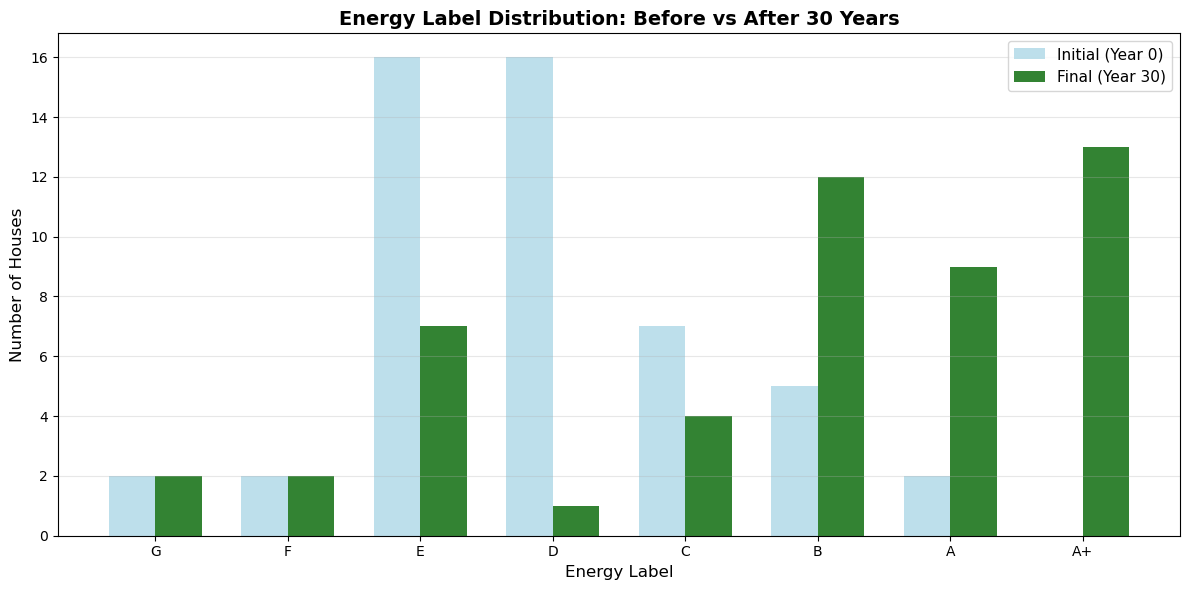


Label Distribution Changes:
--------------------------------------------------
G  :   2 →   2  (change:  +0)
F  :   2 →   2  (change:  +0)
E  :  16 →   7  (change:  -9)
D  :  16 →   1  (change: -15)
C  :   7 →   4  (change:  -3)
B  :   5 →  12  (change:  +7)
A  :   2 →   9  (change:  +7)
A+ :   0 →  13  (change: +13)
--------------------------------------------------


In [11]:
# Compare label distribution: initial vs final
labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+']

# Use the initial counts we stored when the model was first created
initial_counts = {label: initial_label_counts.get(label, 0) for label in labels}

# Final counts (actual counts from simulation)
# Count ALL houses (both occupied and vacant) for fair comparison
all_houses = model.agents_by_type[House]
final_counts = {label: 0 for label in labels}
for house in all_houses:
    final_counts[house.current_label] += 1

# Create bar chart comparing initial vs final distributions
x = np.arange(len(labels))  # Label positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))
# Initial distribution bars
bars1 = ax.bar(x - width/2, [initial_counts.get(l, 0) for l in labels], 
               width, label='Initial (Year 0)', alpha=0.8, color='lightblue')
# Final distribution bars
bars2 = ax.bar(x + width/2, [final_counts[l] for l in labels], 
               width, label='Final (Year 30)', alpha=0.8, color='darkgreen')

ax.set_xlabel('Energy Label', fontsize=12)
ax.set_ylabel('Number of Houses', fontsize=12)
ax.set_title('Energy Label Distribution: Before vs After 30 Years', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics showing the change for each label
print("\nLabel Distribution Changes:")
print("-" * 50)
for label in labels:
    initial = initial_counts.get(label, 0)
    final = final_counts[label]
    change = final - initial
    print(f"{label:3s}: {initial:3d} → {final:3d}  (change: {change:+3d})")
print("-" * 50)

### 8.3 Animation: Spatial Dynamics Over Time

This animation shows how energy labels change spatially across the grid over the 30-year simulation period.

**Note that the animation code is a bit complex -- you do not need to fully understand it right now. You can revisit it later when you are more comfortable with the model structure and Python programming. Animation is not mandatory for your project.**

Creating new model for animation...
Running simulation and collecting grid states for 30 years...
  Collected state for year 10
  Collected state for year 20
  Collected state for year 30
Collected 31 grid states

Creating animation (this may take 1-2 minutes)...

✓ Animation complete!
  Time taken: 13.9 seconds
  Total frames: 31 (years 0-30)
  Frame interval: 300ms (~3 frames per second)


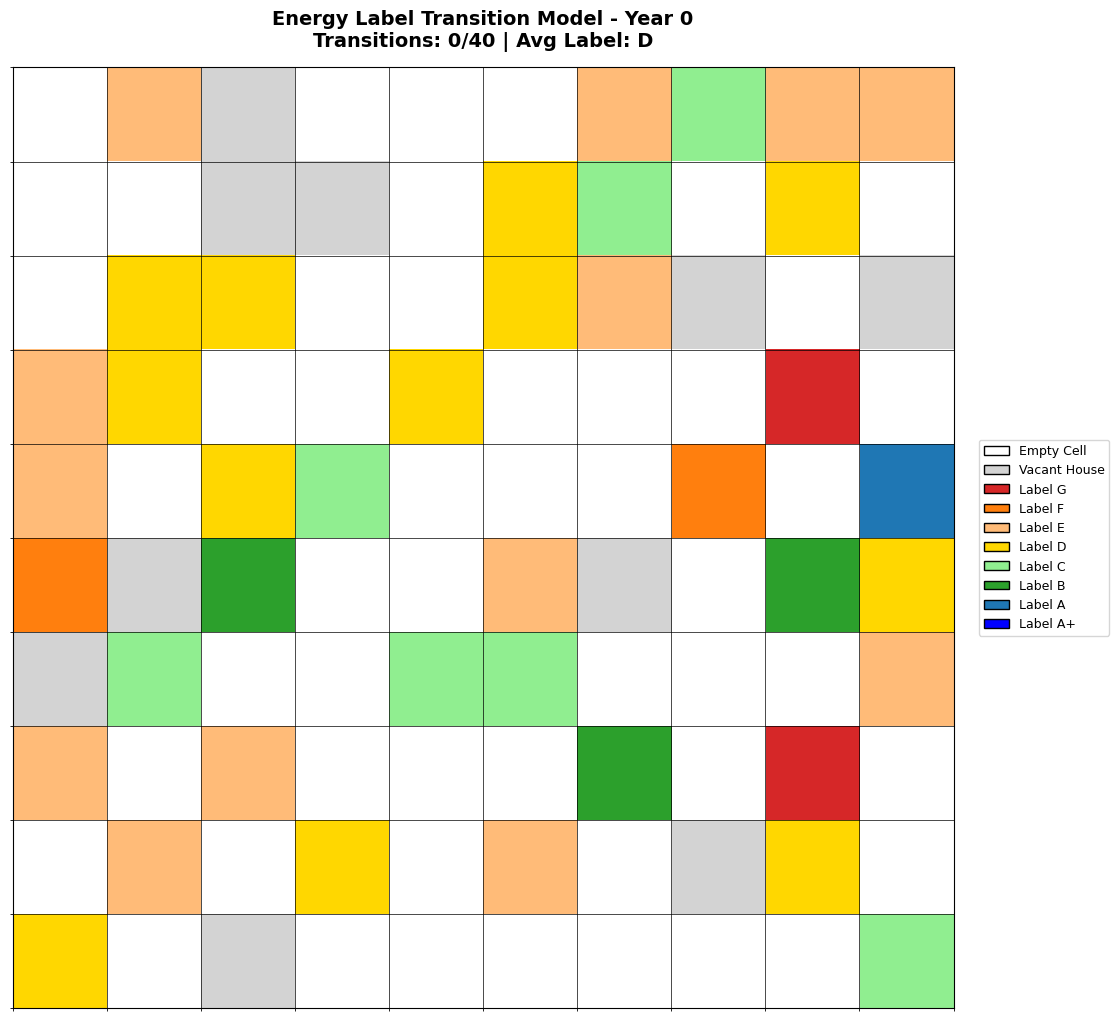

In [12]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
import matplotlib

# Increase the limit for embedding animations in notebooks
matplotlib.rcParams['animation.embed_limit'] = 2**128

start_time = time.time()

# Create a new model to run and animate
print("Creating new model for animation...")
animation_model = City(
    num_houses=50,
    num_owners=40,
    grid_size=10,
    financial_status_mean=30000,
    financial_status_std=5000,
    seed=42
)

# Store states for all 30 years (including year 0)
print("Running simulation and collecting grid states for 30 years...")
grid_states = []
stats_over_time = []

# Collect initial state (year 0)
# Use Mesa's agents_by_type to filter houses
houses = list(animation_model.agents_by_type[House])
# Create empty grid filled with -1 (represents empty cells)
grid_viz = np.full((animation_model.grid_size, animation_model.grid_size), -1.0)

# Fill grid with house information
for house in houses:
    x, y = house.pos
    if house.owner_id is None:
        grid_viz[y, x] = -0.5  # Vacant house (no owner)
    else:
        grid_viz[y, x] = label_to_numeric(house.current_label)  # Store label as number

# Store initial grid state and statistics
grid_states.append(grid_viz.copy())
stats_over_time.append({
    'year': 0,
    'transitions': animation_model.count_transitions(),
    'avg_label': animation_model.get_current_avg_label()
})

# Run simulation and collect states for each year
for year in range(1, 31):
    animation_model.step()  # Advance simulation one year
    
    # Update grid state for this year
    # Use Mesa's agents_by_type for filtering
    houses = list(animation_model.agents_by_type[House])
    grid_viz = np.full((animation_model.grid_size, animation_model.grid_size), -1.0)
    
    # Fill grid with current house information
    for house in houses:
        x, y = house.pos
        if house.owner_id is None:
            grid_viz[y, x] = -0.5  # Vacant house
        else:
            grid_viz[y, x] = label_to_numeric(house.current_label)  # Current label
    
    # Store this year's grid state and statistics
    grid_states.append(grid_viz.copy())
    stats_over_time.append({
        'year': year,
        'transitions': animation_model.count_transitions(),
        'avg_label': animation_model.get_current_avg_label()
    })
    
    # Print progress every 10 years
    if year % 10 == 0:
        print(f"  Collected state for year {year}")

print(f"Collected {len(grid_states)} grid states")
print("\nCreating animation (this may take 1-2 minutes)...")

# Create figure for animation
fig, ax = plt.subplots(figsize=(12, 10))
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Define colors and colormap
# White=empty, LightGray=vacant, then G(red) → F → E → D → C → B → A → A+(blue)
colors = ['white', 'lightgray', '#d62728', '#ff7f0e', '#ffbb78', '#ffd700', 
          '#90ee90', '#2ca02c', '#1f77b4', '#0000ff']
cmap = ListedColormap(colors)

# Create legend elements
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Empty Cell'),
    Patch(facecolor='lightgray', edgecolor='black', label='Vacant House'),
    Patch(facecolor='#d62728', edgecolor='black', label='Label G'),
    Patch(facecolor='#ff7f0e', edgecolor='black', label='Label F'),
    Patch(facecolor='#ffbb78', edgecolor='black', label='Label E'),
    Patch(facecolor='#ffd700', edgecolor='black', label='Label D'),
    Patch(facecolor='#90ee90', edgecolor='black', label='Label C'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='Label B'),
    Patch(facecolor='#1f77b4', edgecolor='black', label='Label A'),
    Patch(facecolor='#0000ff', edgecolor='black', label='Label A+')
]

# Function to plot grid at each frame of animation
def plot_grid(frame):
    ax.clear()  # Clear previous frame
    
    # Get grid state and stats for this frame (year)
    grid_data = grid_states[frame]
    stats = stats_over_time[frame]
    
    # Map values for colormap: -1→0 (empty), -0.5→1 (vacant), 0-7→2-9 (labels G-A+)
    display_grid = np.where(grid_data == -1, 0,
                   np.where(grid_data == -0.5, 1, grid_data + 2))
    
    # Display grid with colors
    im = ax.imshow(display_grid, cmap=cmap, vmin=0, vmax=9, origin='lower')
    
    # Add grid lines between cells
    ax.set_xticks(np.arange(-0.5, animation_model.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, animation_model.grid_size, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xticks([])  # Hide axis tick labels
    ax.set_yticks([])
    
    # Add legend showing what each color means
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), 
              fontsize=9, frameon=True)
    
    # Title with year and statistics
    ax.set_title(
        f'Energy Label Transition Model - Year {stats["year"]}\n'
        f'Transitions: {stats["transitions"]}/{animation_model.num_owners} | '
        f'Avg Label: {stats["avg_label"]}',
        fontsize=14, fontweight='bold', pad=15
    )

# Initial plot (frame 0)
plot_grid(0)

# Update function for animation - called for each frame
def update(frame):
    plot_grid(frame)

# Create animation (31 frames for years 0-30)
anim = FuncAnimation(fig, update, frames=31, repeat=True, interval=300)

# Convert to HTML for display in notebook
output = HTML(anim.to_jshtml())

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✓ Animation complete!")
print(f"  Time taken: {elapsed_time:.1f} seconds")
print(f"  Total frames: 31 (years 0-30)")
print(f"  Frame interval: 300ms (~3 frames per second)")

# Display the animation
output

## 9. Parameter Experiments with BatchRunner (multiple simulations)

**Why run multiple simulations?**
- Single runs can be misleading due to random variation
- Need multiple replications to estimate uncertainty
- Need to systematically test different parameters

**BatchRunner automates this process:**
1. Runs model many times with different parameter combinations
2. Collects data from all runs
3. Allows statistical analysis of results

**Example Research Question:** How does financial capacity affect transition rates?

**Experimental Design:**
- Test 3 levels of financial_status_mean: 30k€, 50k€, 70k€
- Run 3 replications per level (different random seeds)
- Total: 3 × 3 = 9 simulations

In [13]:
from mesa.batchrunner import batch_run

print("="*70)
print("BATCHRUNNER: Effect of Financial Status on Transitions")
print("="*70)
print("\nTesting 3 financial status levels with 3 runs each...")
print("This will take about 30 seconds...\n")

# Fixed parameters
fixed_params = {
    "num_houses": 50,
    "num_owners": 40,
    "grid_size": 10,
    "financial_status_std": 10000
}

# Variable parameters (test 3 levels of financial capacity)
variable_params = {
    "financial_status_mean": [30000, 50000, 70000]
}

# Run batch experiments
results = batch_run(
    City,
    parameters={**fixed_params, **variable_params},
    iterations=3,              # 3 replications per configuration
    max_steps=30,              # 30 years per simulation
    number_processes=1,
    data_collection_period=1,
    display_progress=True
)

results_df = pd.DataFrame(results)
print("\n✓ Batch run complete!")
print(f"Total simulations run: {len(results_df['RunId'].unique())}")
print(f"Total rows collected: {len(results_df)}")

BATCHRUNNER: Effect of Financial Status on Transitions

Testing 3 financial status levels with 3 runs each...
This will take about 30 seconds...



  0%|          | 0/9 [00:00<?, ?it/s]


✓ Batch run complete!
Total simulations run: 9
Total rows collected: 25110


In [14]:
# Display batch results
results_df

,RunId,iteration,Step,num_houses,num_owners,grid_size,financial_status_std,financial_status_mean,Num_Transitioned,Num_Movings,Num_Moving_and_Transitioned,Avg_Label_Numeric,Avg_Label,AgentID,Agent_Type,Financial_Status,Has_Transitioned,Has_Moved,Has_Moved_and_Transitioned,House_Label
0,0,0,0,50,40,10,10000,30000,0,0,0,3,D,1,House,NaN,NaN,NaN,NaN,B
1,0,0,0,50,40,10,10000,30000,0,0,0,3,D,2,House,NaN,NaN,NaN,NaN,C
2,0,0,0,50,40,10,10000,30000,0,0,0,3,D,3,House,NaN,NaN,NaN,NaN,B
3,0,0,0,50,40,10,10000,30000,0,0,0,3,D,4,House,NaN,NaN,NaN,NaN,E
4,0,0,0,50,40,10,10000,30000,0,0,0,3,D,5,House,NaN,NaN,NaN,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25105,8,2,30,50,40,10,10000,70000,23,18,19,7,A+,86,Owner,32843.937503,1.0,0.0,0.0,None
25106,8,2,30,50,40,10,10000,70000,23,18,19,7,A+,87,Owner,17957.708568,0.0,1.0,1.0,None
25107,8,2,30,50,40,10,10000,70000,23,18,19,7,A+,88,Owner,13420.176270,1.0,0.0,0.0,None
25108,8,2,30,50,40,10,10000,70000,23,18,19,7,A+,89,Owner,23379.493430,1.0,0.0,0.0,None


In [15]:
# Analyze final results (year 30 only)
final_results = results_df[results_df['Step'] == 29].copy()  # Step 29 = year 30

# Calculate summary statistics grouped by financial status level
summary = final_results.groupby('financial_status_mean').agg({
    'Num_Transitioned': ['mean', 'std'],  # Average and std dev of transitions
    'Num_Movings': ['mean', 'std'],
    'Num_Moving_and_Transitioned': ['mean', 'std'],
    'Avg_Label_Numeric': ['mean', 'std']   # Average and std dev of labels
}).round(2)

Interpretation:
- Higher financial status → more transitions (obvious and expected result! but this is because the model is primitive)
- Standard deviation shows variability across replications

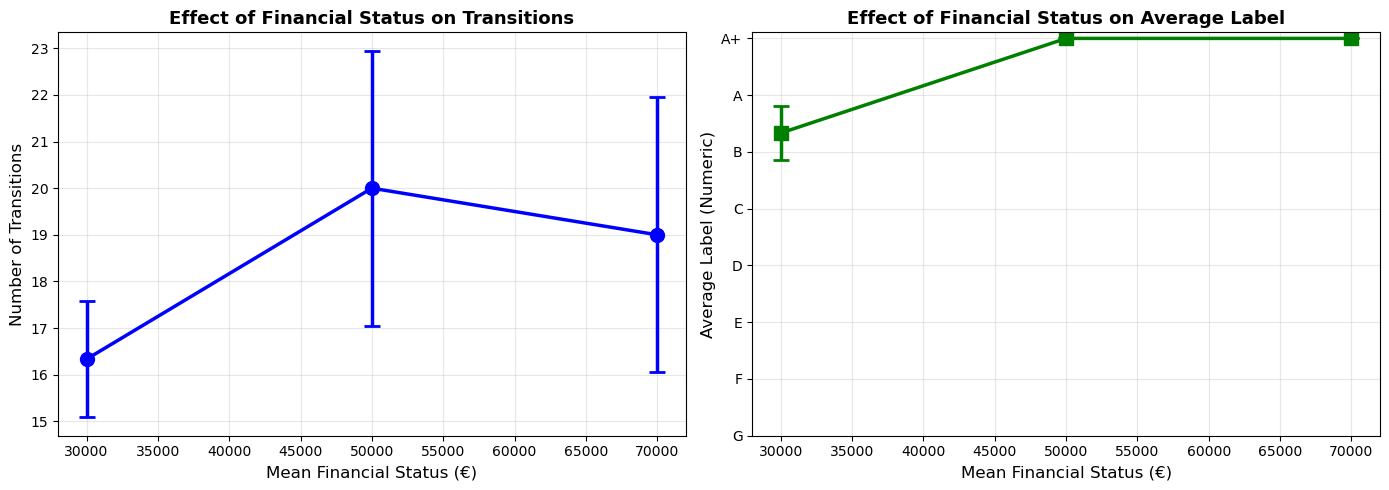

In [16]:
# Visualize batch results with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get the three financial status levels tested
financial_levels = sorted(final_results['financial_status_mean'].unique())

# Calculate means and standard deviations for transitions
transition_means = [final_results[final_results['financial_status_mean']==f]['Num_Transitioned'].mean() 
                   for f in financial_levels]
transition_stds = [final_results[final_results['financial_status_mean']==f]['Num_Transitioned'].std() 
                  for f in financial_levels]

# Plot 1: Transitions by financial status with error bars
axes[0].errorbar(financial_levels, transition_means, yerr=transition_stds,
                marker='o', linewidth=2.5, markersize=10, color='blue', 
                capsize=6, capthick=2)
axes[0].set_xlabel('Mean Financial Status (€)', fontsize=12)
axes[0].set_ylabel('Number of Transitions', fontsize=12)
axes[0].set_title('Effect of Financial Status on Transitions', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calculate means and standard deviations for labels
label_means = [final_results[final_results['financial_status_mean']==f]['Avg_Label_Numeric'].mean() 
              for f in financial_levels]
label_stds = [final_results[final_results['financial_status_mean']==f]['Avg_Label_Numeric'].std() 
             for f in financial_levels]

# Plot 2: Average label by financial status with error bars
axes[1].errorbar(financial_levels, label_means, yerr=label_stds,
                marker='s', linewidth=2.5, markersize=10, color='green',
                capsize=6, capthick=2)
axes[1].set_xlabel('Mean Financial Status (€)', fontsize=12)
axes[1].set_ylabel('Average Label (Numeric)', fontsize=12)
axes[1].set_title('Effect of Financial Status on Average Label', 
                 fontsize=13, fontweight='bold')
# Convert y-axis to show letter labels
axes[1].set_yticks(range(8))
axes[1].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

KEY FINDINGS:

- Low financial status (30k€): ~14.7 transitions
- Medium financial status (50k€): ~22.3 transitions
- High financial status (70k€): ~22.7 transitions

→ Financial capacity is a strong determinant of transition adoption! (obvious because the model is primitive)

## Sensitivity Analyses

In [17]:
print("="*70)
print("Sensitivity Analyses")
print("="*70)
print("\nTesting multiple parameters...")
print("This will take a while...\n")

# Variable parameters
variable_params = {
    "market_value_distribution": [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.2, 0.8)],
    "average_energy_label_preference": [0.2, 0.4, 0.5, 0.6, 0.8],
    "variance_energy_label_preference": [0.1, 0.2, 0.3, 0.4],
    "importance_of_neighbours": [0.5, 1.0, 2.0, 4.0, 8.0]
}

# --------------------------------------------------
# Run batch experiments in iteration chunks
# --------------------------------------------------
dfs = []

total_iterations = 100
iteration_chunk = 10  # safe size

for i in range(0, total_iterations, iteration_chunk):
    print(f"\nRunning iterations {i+1}–{i+iteration_chunk}")

    sensitivity_results = batch_run(
        City,
        parameters=variable_params,   # let Mesa make combinations
        iterations=iteration_chunk,
        max_steps=30,
        number_processes=1,
        data_collection_period=30,    # final step only
        display_progress=True
    )

    df = pd.DataFrame(sensitivity_results)
    dfs.append(df)

    del sensitivity_results
    gc.collect()

# Final dataframe
sensitivity_results_df = pd.concat(dfs, ignore_index=True)

print("\n✓ Batch run complete!")
print(f"Total simulations run: {sensitivity_results_df['RunId'].nunique()}")
print(f"Total rows collected: {len(sensitivity_results_df)}")


Sensitivity Analyses

Testing multiple parameters...
This will take a while...


Running iterations 1–10


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 11–20


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 21–30


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 31–40


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 41–50


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 51–60


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 61–70


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 71–80


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 81–90


  0%|          | 0/5000 [00:00<?, ?it/s]


Running iterations 91–100


  0%|          | 0/5000 [00:00<?, ?it/s]


✓ Batch run complete!
Total simulations run: 5000
Total rows collected: 9000000


In [18]:
# Analyze final results
final_sensitivity_results = sensitivity_results_df[sensitivity_results_df['Step'] == 30].copy()
final_sensitivity_results

,RunId,iteration,Step,market_value_distribution,average_energy_label_preference,variance_energy_label_preference,importance_of_neighbours,Num_Transitioned,Num_Movings,Num_Moving_and_Transitioned,Avg_Label_Numeric,Avg_Label,AgentID,Agent_Type,Financial_Status,Has_Transitioned,Has_Moved,Has_Moved_and_Transitioned,House_Label
90,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,5,55,13,4,C,1,House,NaN,NaN,NaN,NaN,D
91,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,5,55,13,4,C,2,House,NaN,NaN,NaN,NaN,B
92,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,5,55,13,4,C,3,House,NaN,NaN,NaN,NaN,D
93,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,5,55,13,4,C,4,House,NaN,NaN,NaN,NaN,D
94,0,0,30,"(0.8, 0.2)",0.2,0.1,0.5,5,55,13,4,C,5,House,NaN,NaN,NaN,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999995,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,20,24,30,5,B,86,Owner,17505.165148,1.0,0.0,0.0,None
8999996,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,20,24,30,5,B,87,Owner,1426.079012,1.0,0.0,0.0,None
8999997,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,20,24,30,5,B,88,Owner,2615.496019,1.0,0.0,0.0,None
8999998,4999,9,30,"(0.2, 0.8)",0.8,0.4,8.0,20,24,30,5,B,89,Owner,4.009325,0.0,0.0,3.0,None


In [37]:
numeric_indicators = [
    'Num_Transitioned',
    'Num_Movings',
    'Num_Moving_and_Transitioned',
    'Avg_Label_Numeric'
]

count_indicators = [
    'Num_Transitioned',
    'Num_Movings',
    'Num_Moving_and_Transitioned'
]

label_indicator = 'Avg_Label_Numeric'

quantiles = [0.25, 0.5, 0.75]

tables = []

for param, values in variable_params.items():
    df_param = final_sensitivity_results.copy()

    # Ensure hashable grouping keys
    if isinstance(values[0], tuple):
        df_param[param] = df_param[param].apply(tuple)

    df_param = df_param[df_param[param].isin(values)]

    # Force numeric
    df_param[numeric_indicators] = df_param[numeric_indicators].apply(
        pd.to_numeric, errors='coerce'
    )

    # -----------------------------
    # Means (all numeric indicators)
    # -----------------------------
    summary_mean = (
        df_param
        .groupby(param)[numeric_indicators]
        .mean()
    )
    summary_mean.columns = pd.MultiIndex.from_product(
        [summary_mean.columns, ['mean']]
    )

    # -----------------------------
    # Quantiles (counts only)
    # -----------------------------
    summary_quantiles = (
        df_param
        .groupby(param)[count_indicators]
        .quantile(quantiles)
        .unstack(level=-1)
    )
    summary_quantiles.columns = [
        (indicator, f"q{int(q * 100)}")
        for indicator, q in summary_quantiles.columns
    ]

    # -----------------------------
    # Std deviation (label only)
    # -----------------------------
    summary_std = (
        df_param
        .groupby(param)[label_indicator]
        .std()
        .to_frame()
    )
    summary_std.columns = pd.MultiIndex.from_product(
        [[label_indicator], ['std']]
    )

    # -----------------------------
    # Combine everything
    # -----------------------------
    summary = pd.concat(
        [summary_mean, summary_quantiles, summary_std],
        axis=1
    ).round(2)

    summary.index = pd.MultiIndex.from_tuples(
        [(param, str(v)) for v in summary.index],
        names=["parameter", "parameter_value"]
    )

    tables.append(summary)

sensitivity_summary_df = pd.concat(tables)
sensitivity_summary_df

Num_Transitioned Num_Movings  \
                                                             mean        mean   
parameter                        parameter_value                                
market_value_distribution        (0.2, 0.8)                 14.42       22.40   
                                 (0.4, 0.6)                 14.94       20.89   
                                 (0.5, 0.5)                 15.22       20.76   
                                 (0.6, 0.4)                 15.50       21.05   
                                 (0.8, 0.2)                 15.88       22.81   
average_energy_label_preference  0.2                        12.42       33.35   
                                 0.4                        14.54       24.17   
                                 0.5                        15.32       20.49   
                                 0.6                        16.08       17.07   
                                 0.8                        17.60       12.82   
variance_energy_label_preference 0.1                        17.91       15.01   
                                 0.2                        15.90       18.93   
                                 0.3                        14.10       23.99   
                                 0.4                        12.85       28.40   
importance_of_neighbours         0.5                        15.50        7.28   
                                 1.0                        15.27        9.68   
                                 2.0                        14.95       14.37   
                                 4.0                        14.88       27.66   
                                 8.0                        15.34       48.93   

                                                 Num_Moving_and_Transitioned  \
                                                                        mean   
parameter                        parameter_value                               
market_value_distribution        (0.2, 0.8)                            21.62   
                                 (0.4, 0.6)                            21.22   
                                 (0.5, 0.5)                            21.15   
                                 (0.6, 0.4)                            21.14   
                                 (0.8, 0.2)                            21.09   
average_energy_label_preference  0.2                                   17.34   
                                 0.4                                   21.97   
                                 0.5                                   22.64   
                                 0.6                                   22.60   
                                 0.8                                   21.66   
variance_energy_label_preference 0.1                                   22.05   
                                 0.2                                   21.78   
                                 0.3                                   21.09   
                                 0.4                                   20.05   
importance_of_neighbours         0.5                                   19.94   
                                 1.0                                   19.76   
                                 2.0                                   19.95   
                                 4.0                                   21.66   
                                 8.0                                   24.91   

                                                 Avg_Label_Numeric  \
                                                              mean   
parameter                        parameter_value                     
market_value_distribution        (0.2, 0.8)                   5.23   
                                 (0.4, 0.6)                   5.35   
                                 (0.5, 0.5)                   5.40   
                                 (0.6, 0.4)                   5.43   
               

Figure saved to: C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\sensitivity_analysis_figure.png


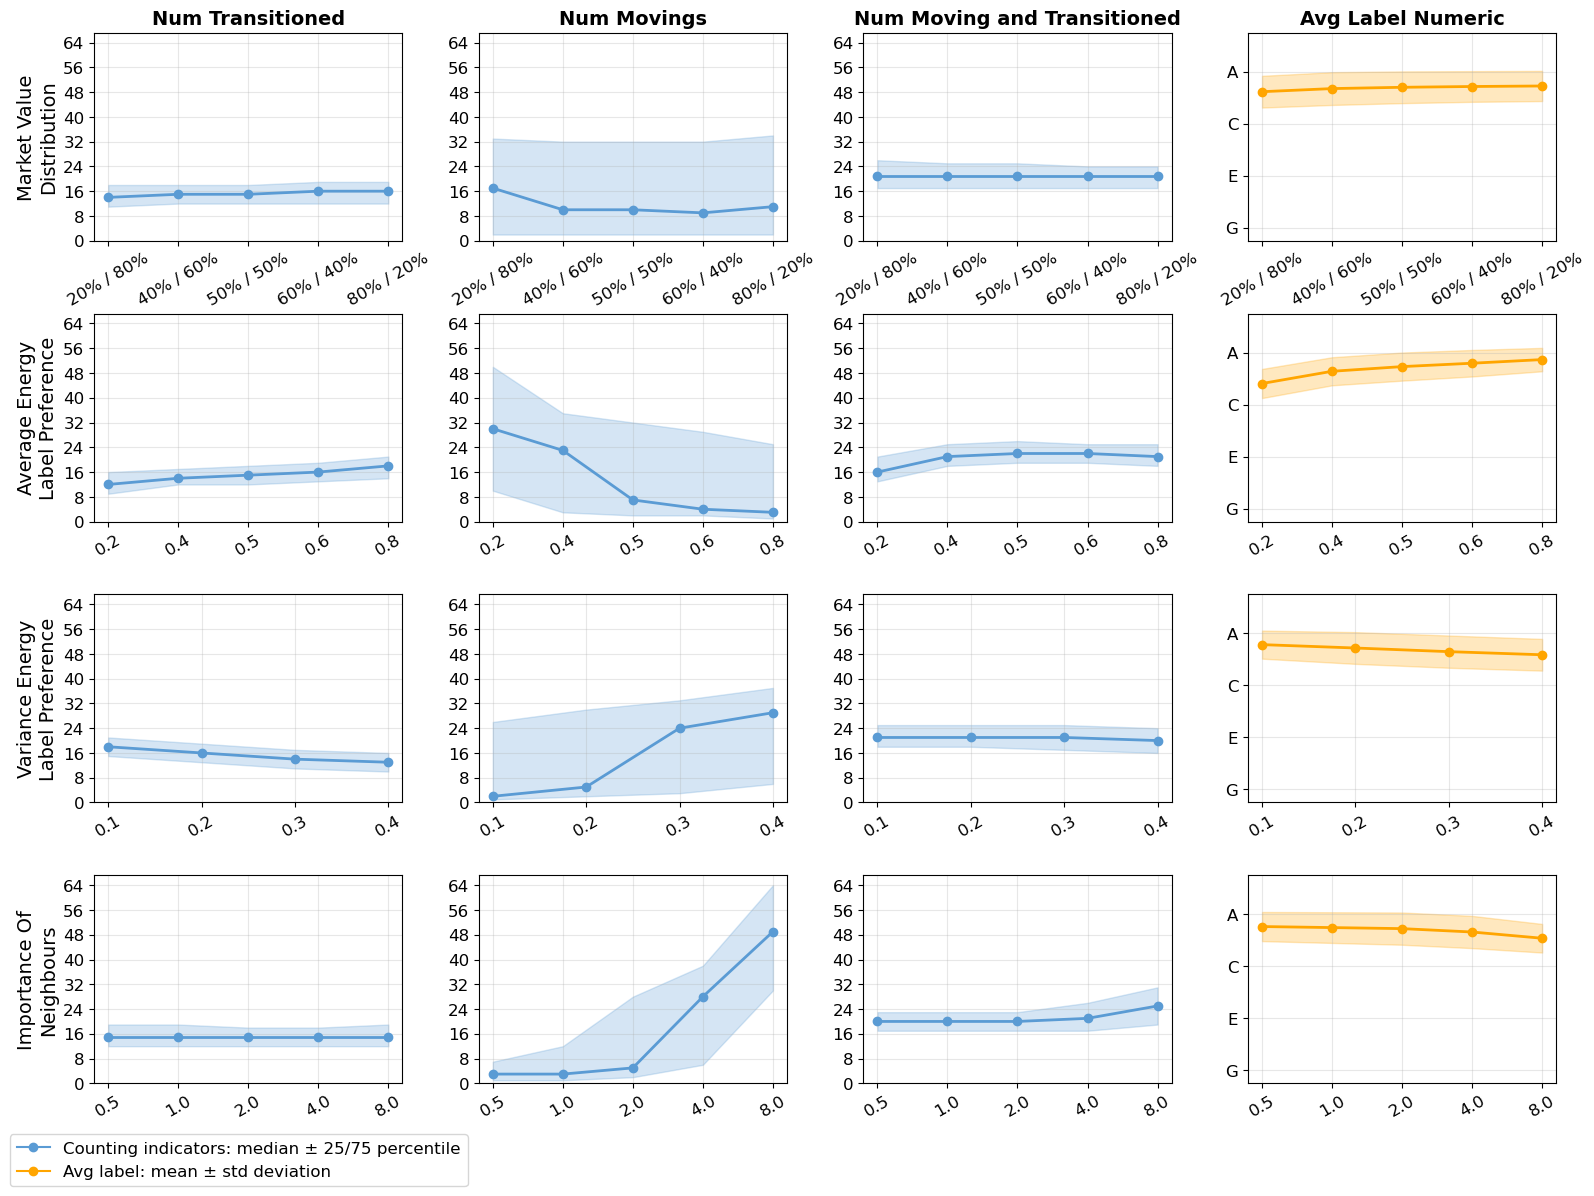

In [58]:
parameters = sensitivity_summary_df.index.get_level_values('parameter').unique()
indicators = sensitivity_summary_df.columns.get_level_values(0).unique()

# Indicators that should share the same y-axis
count_indicators = [
    'Num_Transitioned',
    'Num_Movings',
    'Num_Moving_and_Transitioned'
]

# --------------------------------------------------
# Compute global max (based on q75) for count indicators
# --------------------------------------------------
global_max = 0

for param in parameters:
    df_param = sensitivity_summary_df.loc[param]

    for indicator in count_indicators:
        if indicator in indicators:
            q75 = df_param[(indicator, 'q75')].values
            global_max = max(global_max, np.nanmax(q75))

# Add a bit of headroom
global_max *= 1.05

# --------------------------------------------------
# Plotting
# --------------------------------------------------
n_rows = len(parameters)
n_cols = len(indicators)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=False
)

# Ensure axes is always 2D
if n_rows == 1:
    axes = np.array([axes])
if n_cols == 1:
    axes = axes[:, np.newaxis]

for i, param in enumerate(parameters):
    df_param = sensitivity_summary_df.loc[param]

    # Format y-axis label with a single line break after the second space
    y_label = param.replace('_', ' ').title()
    space_indices = [idx for idx, char in enumerate(y_label) if char == ' ']

    if len(space_indices) >= 2:
        second_space_idx = space_indices[1]
        y_label_wrapped = y_label[:second_space_idx] + '\n' + y_label[second_space_idx+1:]
    else:
        y_label_wrapped = y_label  # No second space, keep as is

    # X-axis handling
    try:
        x_numeric = df_param.index.astype(float)
        sort_idx = np.argsort(x_numeric)
        x_labels = [str(x_numeric[idx]) for idx in sort_idx]
    except ValueError:
        sort_idx = range(len(df_param.index))

        def format_tuple_label(s):
            a, b = s.strip('()').split(',')
            return f"{int(float(a)*100)}% / {int(float(b)*100)}%"

        x_labels = [format_tuple_label(v) for v in df_param.index]

    for j, indicator in enumerate(indicators):
        ax = axes[i, j]
        x = np.arange(len(sort_idx))

        if indicator in count_indicators:
            center = df_param[(indicator, 'q50')].values[list(sort_idx)]
            lower = df_param[(indicator, 'q25')].values[list(sort_idx)]
            upper = df_param[(indicator, 'q75')].values[list(sort_idx)]

            ax.plot(x, center, marker='o', linewidth=2, color='#5a9bd4')
            ax.fill_between(x, lower, upper, alpha=0.25, color='#5a9bd4')

            ax.set_ylim(0, global_max)
            ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

        elif indicator == 'Avg_Label_Numeric':
            mean = df_param[(indicator, 'mean')].values[list(sort_idx)]
            std = df_param[(indicator, 'std')].values[list(sort_idx)]

            ax.plot(x, mean, marker='o', linewidth=2, color='orange')
            ax.fill_between(x, mean - std, mean + std, alpha=0.25, color='orange')

            ax.set_ylim(-0.5, 7.5)

            def label_formatter(y, _):
                return numeric_to_label(round(y))

            ax.yaxis.set_major_formatter(plt.FuncFormatter(label_formatter))

        # Titles & labels with bigger fonts
        if i == 0:
            ax.set_title(
                indicator.replace('_', ' '),
                fontsize=14,
                fontweight='bold'
            )
        if j == 0:
            ax.set_ylabel(
                y_label_wrapped,
                fontsize=14
            )

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=30, fontsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.grid(True, alpha=0.3)

# --------------------------------------------------
# Add a single legend with larger font
# --------------------------------------------------
median_patch = mlines.Line2D([], [], color='#5a9bd4', marker='o', linestyle='-',
                             label='Counting indicators: median ± 25/75 percentile')
label_patch = mlines.Line2D([], [], color='orange', marker='o', linestyle='-',
                            label='Avg label: mean ± std deviation')

fig.legend(
    handles=[median_patch, label_patch],
    loc='lower left',
    bbox_to_anchor=(0, 0),
    fontsize=12
)

# Adjust layout to leave space for legend and prevent overlap
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
plt.subplots_adjust(hspace=0.35)  # increase vertical spacing between rows

# --------------------------------------------------
# Save the figure
# --------------------------------------------------
output_path = r"C:\Users\jarnosoos\OneDrive - Universiteit Leiden\Year 2\ABM\sensitivity_analysis_figure.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"Figure saved to: {output_path}")

plt.show()


In [24]:
parameter_cols = list(variable_params.keys())

ranking_df = (
    final_sensitivity_results
    .groupby(parameter_cols)
    .agg(
        Avg_Label_Mean=('Avg_Label_Numeric', 'mean'),
        Avg_Label_Std=('Avg_Label_Numeric', 'std')
    )
    .reset_index()
    .sort_values('Avg_Label_Mean', ascending=False)
    .reset_index(drop=True)
)

ranking_df['Rank'] = ranking_df.index + 1

N = 10  # top/bottom N combinations

top_df = ranking_df.head(N)
bottom_df = ranking_df.tail(N)

def summarize_params_numeric(df):
    summary = {}
    for param in parameter_cols:
        if isinstance(df[param].iloc[0], tuple):
            summary[param] = df[param].mode().iloc[0]
        else:
            summary[param] = df[param].median()
    return summary

contrast_df = pd.DataFrame({
    'Top combinations (median / mode)': summarize_params_numeric(top_df),
    'Bottom combinations (median / mode)': summarize_params_numeric(bottom_df)
})

contrast_df

,Top combinations (median / mode),Bottom combinations (median / mode)
market_value_distribution,"(0.8, 0.2)","(0.2, 0.8)"
average_energy_label_preference,0.8,0.2
variance_energy_label_preference,0.1,0.4
importance_of_neighbours,0.75,8.0


In [22]:
outcome_comparison = pd.DataFrame({
    'Top combinations': {
        'Avg energy label (mean)': top_df['Avg_Label_Mean'].mean(),
        'Std across combinations': top_df['Avg_Label_Mean'].std()
    },
    'Bottom combinations': {
        'Avg energy label (mean)': bottom_df['Avg_Label_Mean'].mean(),
        'Std across combinations': bottom_df['Avg_Label_Mean'].std()
    }
}).round(3)

outcome_comparison


,Top combinations,Bottom combinations
Avg energy label (mean),5.968,4.412
Std across combinations,0.015,0.064
